# pICAxou

parallel Independent Component Analyis for Xross 'Omics Unification (Unity?) 

In [1]:
import glob
import multiprocessing
import pickle

import pandas as pd
import numpy as np
import tqdm
from p_tqdm import p_map
from pybedtools import BedTool
import pyBigWig as bw
from sklearn.decomposition import FastICA
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import swifter

%matplotlib inline

## Generating data files

In [2]:
gex = pd.read_excel('/Volumes/nimer/Bioinformatic-analyses/GLORIA/SN22 RNAseq DPF2 mice/results/SN22_R1/DESeq2_results/ALL-samples-blind-variance-stabilized-log2-counts.xlsx')

In [3]:
KO_overlap = BedTool('/Volumes/nimer/Bioinformatic-analyses/GLORIA/2019_10_04_ATACseq/DPF2_KO/overlap/optimal_peak.narrowPeak.gz')
FF_overlap = BedTool('/Volumes/nimer/Bioinformatic-analyses/GLORIA/2019_10_04_ATACseq/DPF2_FF/overlap/optimal_peak.narrowPeak.gz')

In [4]:
atac = KO_overlap.cat(FF_overlap, postmerge=True).to_dataframe()

In [5]:
FF_bws = {file.split('/')[-1].split('.')[0]: bw.open(file) for file in glob.glob('/Volumes/nimer/Bioinformatic-analyses/GLORIA/2019_10_04_ATACseq/DPF2_FF/bw/*fc.signal.bigwig')}
KO_bws = {file.split('/')[-1].split('.')[0]: bw.open(file) for file in glob.glob('/Volumes/nimer/Bioinformatic-analyses/GLORIA/2019_10_04_ATACseq/DPF2_KO/bw/*fc.signal.bigwig')}

In [10]:
for k,b in {**FF_bws, **KO_bws}.items():
    atac[k[:-3]] = atac[['chrom','start', 'end']].swifter.apply(lambda x: b.stats(x[0], x[1], x[2])[0], axis=1)

In [12]:
atac.index = atac[['chrom','start','end']].swifter.apply(lambda x: f'{x[0]}:{x[1]}-{x[2]}', axis=1)

In [13]:
atac.to_csv('atac_signal.txt', header=True, index=True, sep="\t")

In [10]:
atac = pd.read_csv('atac_signal.txt', header=0, index_col=0, sep="\t")

In [13]:
atac_cols = ['DPF2_FF_1', 'DPF2_FF_2', 'DPF2_FF_3', 'DPF2_FF_4', 'DPF2_KO_1', 'DPF2_KO_2', 'DPF2_KO_4']

In [3]:
cols =['WT1', 'WT2', 'WT3', 'FF1', 'FF2', 'FF3', 'HET1', 'HET2',
       'HET3', 'HET4', 'KO1', 'KO2', 'KO3', 'KO4', 'KO5', 'KO6']

## Cluster Stability

In [7]:
def cluster_stability(corr_df, cluster_labels):
    '''
    https://doi.org/10.1186/s12864-017-4112-9
    '''    
    
    m_corr = corr_df.copy()
    
    n_clusts = max(cluster_labels) + 1
    n_components = len(m_corr)
    m_corr['cluster'] = cluster_labels
    m_corr.loc['cluster'] = np.append(cluster_labels, np.nan)
    
    m_corr = abs(m_corr)
    
    stability_index = []
    
    for clust in range(n_clusts):
        internal_r = m_corr.loc[m_corr['cluster'] == clust, m_corr.loc['cluster'] == clust]
        clust_size = len(internal_r)
        internal_s = (1/ (clust_size**2)) * internal_r.values.sum()
        
        external_r = m_corr.loc[m_corr['cluster'] == clust, 
                                m_corr.loc['cluster'] != clust].drop(columns=['cluster'])
        scale_ext = 1 / (clust_size * (n_components - clust_size))
        external_s = scale_ext * external_r.values.sum()
        
        stability_index.append(internal_s - external_s)
    
    return np.mean(stability_index), stability_index
        

In [8]:
def kth_ICA(M, k, n_components):
    '''
    M is matrix
    k is number of permutations per cluster to run
    '''
    
    mk = np.array([]).reshape(M.shape[0],0)
    for it in range(k):
        ICA = FastICA(n_components=n_components, random_state=it)
        mk = np.hstack((mk, ICA.fit_transform(M)))
    
    #euclidean distance based on 1-pearson coefficient for clustering
    mk_corr = pd.DataFrame(mk).corr()
    mk_dist = squareform(pdist(1 - abs(mk_corr))) 
    
    ##Clustering to recover groups
    AC = AgglomerativeClustering(n_clusters=n_components, affinity='precomputed', linkage='average')
    labels = AC.fit(mk_dist).labels_
    
    return cluster_stability(pd.DataFrame(mk_corr), labels)

### run on pegasus

## Stability determination

In [4]:
with open('/Volumes/nimer/Bioinformatic-analyses/GLORIA/2019_10_04_ATACseq/Analyses/pica/gex_stability.pkl', 'rb') as file:
    gex_stability = pickle.load(file)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

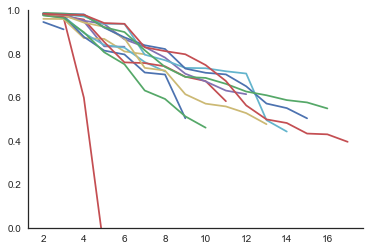

In [20]:
sns.set(style='white', font='arial')

for v in gex_stability.values():
    y = sorted(v[1], reverse=True)
    x = [k + 2 for k in range(len(y))]
    
    plt.plot(x,y)

plt.ylim((0,1))
sns.despine()

In [30]:
all_y = []
all_x = []
for v in gex_stability.values():
    y = sorted(v[1], reverse=True)
    x = [k + 2 for k in range(len(y))]
    
    all_y = [*all_y, *y]
    all_x = [*all_x, *x]

In [33]:
def x2(x, a, b, c):
    return (a * x**2) + (b * x) + c

In [34]:
from scipy.optimize import curve_fit

In [35]:
popt, pcov = curve_fit(x2, all_x, all_y)
fit_y = [x2(x, *popt) for x in sorted(all_x, reverse=True)]

In [53]:
from statsmodels.nonparametric import smoothers_lowess
from scipy.interpolate import interp1d

In [56]:
L = smoothers_lowess.lowess(all_y, all_x)
interp = interp1d(L[:,0], L[:,1])
low_y = interp(sorted(all_x, reverse=True))

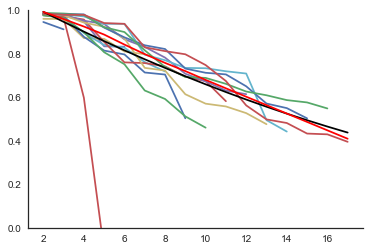

In [58]:
sns.set(style='white', font='arial')

for v in gex_stability.values():
    y = sorted(v[1], reverse=True)
    x = [k + 2 for k in range(len(y))]
    
    plt.plot(x,y)

# 2nd order fit
plt.plot(sorted(all_x, reverse=True), fit_y, 'k')
# lowess fit
plt.plot(sorted(all_x, reverse=True), low_y, 'r-')

plt.ylim((0,1))

sns.despine()


In [10]:
with open('atac_stability.pkl', 'rb') as file:
    atac_stability = pickle.load(file)

In [11]:
atac_ave = [v[1][0] for v in atac_stability.values()]

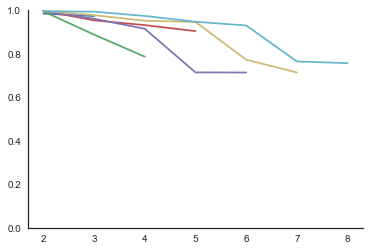

In [21]:
sns.set(style='white', font='arial')

for v in atac_stability.values():
    y = sorted(v[1], reverse=True)
    x = [k + 2 for k in range(len(y))]
    
    plt.plot(x,y)

plt.ylim((0,1))
sns.despine()

Conclusion:  except for outlier, these seem stable out to max components

## Parallel ICA

- make a new pICA that inherits many of the sklearn estimators
- add correlation step in the update

In [6]:
gex_stability[2]

(0.6088926601838205,
 [0.5980445667169103,
  -0.10672700022169135,
  0.9777757641464989,
  0.9664773100935639])

In [4]:
M = gex[cols].copy()

mk = np.array([]).reshape(M.shape[0],0)


for it in tqdm.notebook.tqdm(range(100)):
    ICA = FastICA(n_components=4, random_state=it)
    mk = np.hstack((mk, ICA.fit_transform(M)))

#euclidean distance based on 1-pearson coefficient for clustering
mk_corr = pd.DataFrame(mk).corr()
mk_dist = squareform(pdist(1 - abs(mk_corr))) 

##Clustering to recover groups
AC = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average')
labels = AC.fit(mk_dist).labels_


## Parallel ICA